# Overview
In this case study we will analyze differences in casual and annual membership riders of the Cyclistic bike share company. We will then provide recommendations on how to convert casual riders to annual members. This is a fictional company for the Google Analytics captsone project.

# Ask Phase
Business Task: Analyze differences between casual riders and annual members to design a new marketing strategy to convert current casual riders to annual members. 
* How are casual riders and annual members different? 
* Why would casual riders buy cyclistic annual memberships? 
* How can cyclistic use digital media to influence casual riders to become annual members? 

# Prepare Phase
In this step I am importing necessary modules for my analysis and creating my dataframe. The data is seperated by month in their respective csv files. I am creating a dataframe for each file and then combining all of the dataframes so I can work on a single source of data. The timeline of the data is from September 2023 - August 2024, which will help us understand the recent behavior of casual and member riders. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import re
import seaborn as sns
from scipy.stats import mannwhitneyu
import folium

dataframes = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_file_name = os.path.join(dirname,filename)
        df = pd.read_csv(full_file_name)
        dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)


df.head(10)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,743252713F32516B,classic_bike,2024-04-22 19:08:21,2024-04-22 19:12:56,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,member
1,BE90D33D2240C614,electric_bike,2024-04-11 06:19:24,2024-04-11 06:22:21,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877722,-87.654959,41.878119,-87.643948,member
2,D47BBDDE7C40DD61,classic_bike,2024-04-20 11:13:13,2024-04-20 11:29:31,Sheridan Rd & Montrose Ave,TA1307000107,Ashland Ave & Belle Plaine Ave,13249,41.961670,-87.654640,41.956057,-87.668835,member
3,6684E760BF9EA9B5,classic_bike,2024-04-04 18:39:20,2024-04-04 18:43:06,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,member
4,CA9EFC0D24C24A27,electric_bike,2024-04-19 19:30:20,2024-04-19 20:07:42,Sheridan Rd & Montrose Ave,TA1307000107,Stetson Ave & South Water St,TA1308000029,41.961613,-87.654615,41.886835,-87.622320,member
5,AA64319F52336324,classic_bike,2024-04-10 16:27:08,2024-04-10 16:32:16,Aberdeen St & Jackson Blvd,13157,Loomis St & Lexington St,13332,41.877726,-87.654787,41.872229,-87.661364,member
6,787FC01C61AE054F,electric_bike,2024-04-17 07:58:59,2024-04-17 08:15:53,Clark St & Elm St,TA1307000039,Racine Ave & Belmont Ave,TA1308000019,41.903080,-87.631783,41.939743,-87.658865,member
7,59F25CB1AAC309BA,electric_bike,2024-04-11 18:24:09,2024-04-11 18:30:11,Clark St & Armitage Ave,13146,Clark St & Schiller St,TA1309000024,41.918382,-87.636358,41.907993,-87.631501,member
8,EDF00AC6CCE6AD0A,classic_bike,2024-04-23 20:44:46,2024-04-23 20:51:41,Sheridan Rd & Montrose Ave,TA1307000107,Sheridan Rd & Lawrence Ave,TA1309000041,41.961670,-87.654640,41.969517,-87.654691,member
9,8347307097A1AB52,classic_bike,2024-04-06 15:34:52,2024-04-06 15:53:57,Halsted St & Roscoe St,TA1309000025,Clark St & Schiller St,TA1309000024,41.943670,-87.648950,41.907993,-87.631501,member


The next couple of functions are used to get a better understanding of the columns, data types and any missing values in the dataset. 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5699639 entries, 0 to 5699638
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 565.3+ MB


### Limitations
Based on the dataset we can't determine if riders live in the cyclistic service area or if they have purchased multiple single passes. There is no way to analyze the data by unique customers but we have enough data to do some initial analysis. 

In [3]:
print(df.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name     968697
start_station_id       968697
end_station_name      1006133
end_station_id        1006133
start_lat                   0
start_lng                   0
end_lat                  7526
end_lng                  7526
member_casual               0
dtype: int64


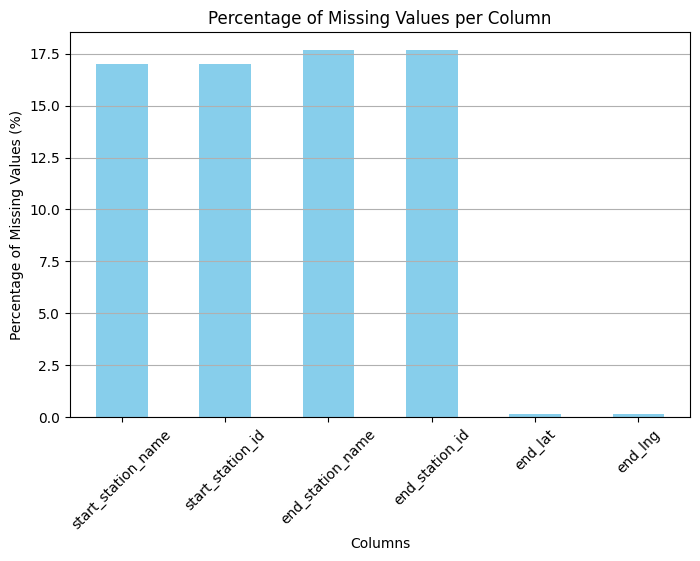

In [4]:
import matplotlib.pyplot as plt

missing_percentage = df.isnull().mean() * 100 #calculating percentage of null values per column
missing_percentage_filtered = missing_percentage[missing_percentage > 0]

plt.figure(figsize=(8, 5))
missing_percentage_filtered.plot(kind='bar', color='skyblue')

# labels
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Missing Data
As seen above there is missing data in the columns: start_station_name, start_station_id, end_station_name, end_station_id, end_lat and end_lng. The portion of missing values in start_station_name and start_station_id seem to coincide so we can conclude that they are dependent on each other. Same with the end_station_name and end_sation_id. About 16-17% of the dataset has missing station data and less the 0.06% of the dataset has missing coordinates, we have to make a decision on whether to drop the missing values or handle them in a different way

# Process Phase
Data cleaning/ transformation and feature engineering. I will be taking steps to make sure my data is clean and accurate. I will also be creating some new features that will be useful for my analsis. 

In [5]:
def clean_data(df):
    df.drop_duplicates(inplace=True)
    df.drop(columns=['start_station_id', 'end_station_id'], inplace=True)
    df.dropna(subset=['end_lat', 'end_lng'], inplace=True) # dropped null values
    df.loc[:, ['start_station_name','end_station_name']] = df.loc[:, ['start_station_name', 'end_station_name']].fillna("unknown")
    df["started_at"] = pd.to_datetime(df['started_at'].str.split('.').str[0]) # conversion to datetime object
    df["ended_at"] = pd.to_datetime(df['ended_at'].str.split('.').str[0])

    return df

df = clean_data(df)
print(df.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
end_station_name      0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


### Data Cleaning
As seen above the count of missing values per column is 0 now. These are the steps I took to clean the data:
1. I dropped any duplicates
2. I dropped the start_station_id and end_station_id columns, they correspond to their station names and I will be using that instead for my analysis. The names of the station are more descriptive.
3. The percentage of missing data for the end_lat and end_lng columns was negligible at 0.1%, leading me to drop those rows
4. The percentage of missing data for the start_station_name and end_station_name columns was substantial at 17%, I changed the missing values to "unknown"
5. I converted the started_at and ended_at columns to datetime objects, this will be useful when I create new features for our analysis

In [6]:
df.rename(columns={'started_at': 'start_time', 'ended_at': 'end_time', 'member_casual':'user_type'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5692113 entries, 0 to 5699638
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   start_station_name  object        
 5   end_station_name    object        
 6   start_lat           float64       
 7   start_lng           float64       
 8   end_lat             float64       
 9   end_lng             float64       
 10  user_type           object        
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 521.1+ MB


I renamed some of the columns so they are more clear. We can also see that the start_time and end_time columns were converted to the correct data type

### Feature engineering
Feature engineering is an essential step to create more variables for our analysis. These are the features I plan to implement for my analysis.
1. distance_mi: Minimum distance in miles from start and end coordinates using the haversine formula which takes into account the earths curvature. The limitation with this approach is that is doen't account for the entire route the rider took.
2. distance_bin: Categorical variable resulting from binning distance
3. duration_min: Calculate ride duration from start to end time
4. duration_bin: Categorical variable resulting from binning ride duration
5. day_of_week: Extracting the day of the week from datetime object
6. month: Extracting the month from the datetime object
7. time_of_day: Categorizes the time of day the ride started

In [7]:
# calculating distance in miles with the haversine formula
from haversine import haversine, Unit
def calculate_distance(row):
    start_coor = (row['start_lat'], row['start_lng'])
    end_coor = (row['end_lat'], row['end_lng'])
    return round(haversine(start_coor, end_coor,  unit = "mi"),2)
df["distance_mi"] = df.apply(calculate_distance, axis = 1)

In [8]:
# creating bins for distance category
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, np.inf ]
labels = ['<0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4+']
df['distance_bin'] = pd.cut(df['distance_mi'], bins, labels=labels, right=False)

In [9]:
# calculating duration in minutes
df['duration_min'] = df.apply(lambda row: round((row["end_time"] - row["start_time"]).total_seconds() / 60, 2), axis = 1)

In [10]:
# creating bins for duration category
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
df['duration_bin'] = pd.cut(df['duration_min'], bins, labels=labels, right=False)

In [11]:
df['day_of_week'] = df['start_time'].dt.day_name() # extracting day from datetime
df['month'] = df['start_time'].dt.month_name() # extracting month from datetime

# categorical column for time of day
def categorize_time(dt):
    if 0 <= dt.hour < 6:
        return 'Night'
    elif 6 <= dt.hour < 12:
        return 'Morning'
    elif 12 <= dt.hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'
df['time_of_day'] = df['start_time'].apply(categorize_time)

df.head(5)

,ride_id,rideable_type,start_time,end_time,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,user_type,distance_mi,distance_bin,duration_min,duration_bin,day_of_week,month,time_of_day
0,743252713F32516B,classic_bike,2024-04-22 19:08:21,2024-04-22 19:12:56,Aberdeen St & Jackson Blvd,Desplaines St & Jackson Blvd,41.877726,-87.654787,41.878119,-87.643948,member,0.56,0.5-1,4.58,<10,Monday,April,Evening
1,BE90D33D2240C614,electric_bike,2024-04-11 06:19:24,2024-04-11 06:22:21,Aberdeen St & Jackson Blvd,Desplaines St & Jackson Blvd,41.877722,-87.654959,41.878119,-87.643948,member,0.57,0.5-1,2.95,<10,Thursday,April,Morning
2,D47BBDDE7C40DD61,classic_bike,2024-04-20 11:13:13,2024-04-20 11:29:31,Sheridan Rd & Montrose Ave,Ashland Ave & Belle Plaine Ave,41.961670,-87.654640,41.956057,-87.668835,member,0.83,0.5-1,16.30,10-20,Saturday,April,Morning
3,6684E760BF9EA9B5,classic_bike,2024-04-04 18:39:20,2024-04-04 18:43:06,Aberdeen St & Jackson Blvd,Desplaines St & Jackson Blvd,41.877726,-87.654787,41.878119,-87.643948,member,0.56,0.5-1,3.77,<10,Thursday,April,Afternoon
4,CA9EFC0D24C24A27,electric_bike,2024-04-19 19:30:20,2024-04-19 20:07:42,Sheridan Rd & Montrose Ave,Stetson Ave & South Water St,41.961613,-87.654615,41.886835,-87.622320,member,5.43,4+,37.37,30-40,Friday,April,Evening


In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_time,5692113,2024-03-23 05:54:56.606331136,2023-09-01 00:00:44,2023-11-15 18:41:19,2024-04-29 17:43:44,2024-07-04 14:46:49,2024-08-31 23:58:30,NaN
end_time,5692113,2024-03-23 06:10:31.040630016,2023-09-01 00:03:06,2023-11-15 18:52:25,2024-04-29 17:57:33,2024-07-04 15:11:08,2024-08-31 23:59:53,NaN
start_lat,5692113.0,41.902564,41.64,41.880958,41.898203,41.93,42.07,0.045092
start_lng,5692113.0,-87.646473,-87.94,-87.66,-87.643118,-87.629525,-87.52,0.02744
end_lat,5692113.0,41.902931,16.06,41.881032,41.898969,41.93,87.96,0.052007
end_lng,5692113.0,-87.646717,-144.05,-87.66,-87.64332,-87.629544,-79.02,0.037486
distance_mi,5692113.0,1.331331,0.0,0.54,0.97,1.73,3250.49,2.216991
duration_min,5692113.0,15.573905,-16656.52,5.57,9.73,17.27,1509.37,36.795575


Seeing negative values for the minutes category which is innacurate. Lets look at some data points to see why that is happening.

In [13]:
print('Percent of negative_values: ',round((df['duration_min'] <0 ).mean() * 100,2))
df[df['duration_min'] < 0].sample(10)

Percent of negative_values:  0.01


,ride_id,rideable_type,start_time,end_time,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,user_type,distance_mi,distance_bin,duration_min,duration_bin,day_of_week,month,time_of_day
1378876,06816F561F0ABD61,electric_bike,2023-10-14 22:26:30,2023-10-14 22:26:29,Millennium Park,Millennium Park,41.881057,-87.624156,41.881032,-87.624084,casual,0.00,<0.5,-0.02,NaN,Saturday,October,Evening
5478925,F152040F707513F8,electric_bike,2023-11-05 01:57:06,2023-11-05 01:05:21,unknown,Clark St & Elm St,41.880000,-87.630000,41.902973,-87.631280,member,1.59,1.5-2,-51.75,NaN,Sunday,November,Night
4847580,94438AD3567A2271,electric_bike,2023-09-07 08:14:06,2023-09-07 08:14:04,Larrabee St & Kingsbury St,unknown,41.897802,-87.642570,41.900000,-87.640000,casual,0.20,<0.5,-0.03,NaN,Thursday,September,Morning
268418,1072195B81B05DAE,electric_bike,2024-04-25 13:37:25,2024-04-25 13:37:22,McClurg Ct & Erie St,unknown,41.894494,-87.617867,41.890000,-87.620000,casual,0.33,<0.5,-0.05,NaN,Thursday,April,Afternoon
4850698,8FC4B7A055502B70,electric_bike,2023-09-10 20:30:38,2023-09-10 20:30:37,Wells St & Hubbard St,unknown,41.890152,-87.634334,41.890000,-87.630000,casual,0.22,<0.5,-0.02,NaN,Sunday,September,Evening
1245414,ED470B3CD09657DF,electric_bike,2024-05-12 15:10:17,2024-05-12 15:10:12,unknown,unknown,41.930000,-87.640000,41.930000,-87.640000,casual,0.00,<0.5,-0.08,NaN,Sunday,May,Afternoon
891450,78FADC5F14A27849,electric_bike,2024-05-31 23:02:34,2024-05-31 23:00:59,unknown,unknown,41.900000,-87.670000,41.900000,-87.670000,casual,0.00,<0.5,-1.58,NaN,Friday,May,Evening
314662,50844DD11A48ECE8,electric_bike,2024-04-29 08:18:38,2024-04-29 08:18:36,unknown,unknown,41.950000,-87.770000,41.950000,-87.770000,member,0.00,<0.5,-0.03,NaN,Monday,April,Morning
311875,B4815ABE997F7075,electric_bike,2024-04-14 14:24:33,2024-04-14 14:24:32,unknown,unknown,41.930000,-87.630000,41.930000,-87.630000,casual,0.00,<0.5,-0.02,NaN,Sunday,April,Afternoon
5636624,368C90D097E27F50,classic_bike,2023-11-05 01:54:53,2023-11-05 01:02:56,Larrabee St & Armitage Ave,Clark St & Drummond Pl,41.918084,-87.643749,41.931248,-87.644336,casual,0.91,0.5-1,-51.95,NaN,Sunday,November,Night


### Innacurate values
After viewing the summary statistics of the dataset, I noticed negative values for the duration minutes column. It's possible that the dates were mixed up or start and end times were switched, however since it only affects 0.01% of the data set I am going to remove those rows to continue my analysis.

In [14]:
drop_rows = df[df['duration_min'] < 0] 
df = df.drop(drop_rows.index)

# Analyze Phase

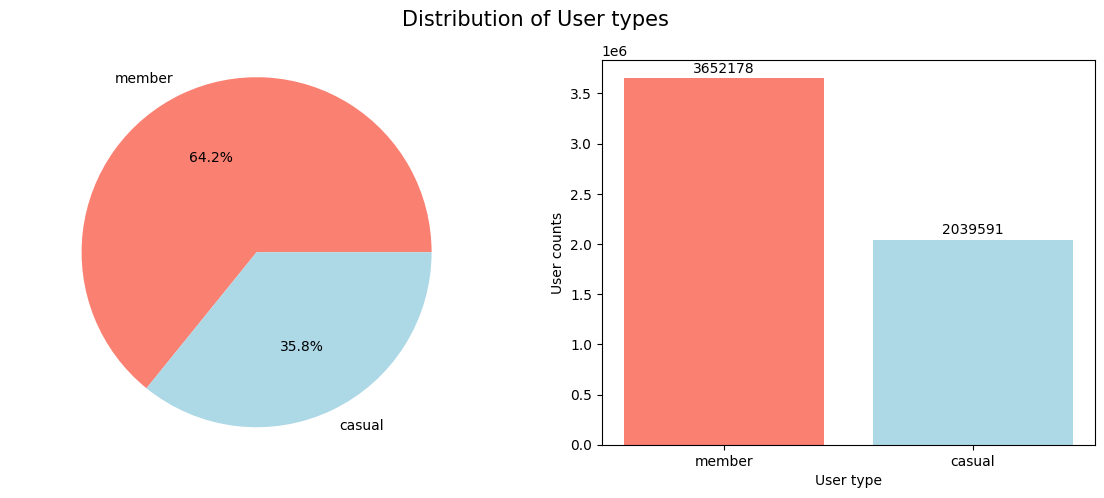

In [15]:
user_counts = df['user_type'].value_counts() # total count by user type
total_counts = len(df)
user_percentage = round(user_counts.div(total_counts) * 100, 2) # percentage of user types in data set
fig, axs = plt.subplots(1,2, figsize=(14,5))

colors = ['salmon', 'lightblue']
axs[0].pie(user_percentage.values, labels = user_percentage.index, autopct='%1.1f%%', colors=colors)
axs[0].axis('equal')

b1 = axs[1].bar(user_counts.index, user_counts.values, label = user_counts.index, color=colors)
axs[1].set_ylabel('User counts')
axs[1].set_xlabel('User type')
axs[1].bar_label(b1, padding=2, fmt="%.0f")


fig.suptitle(f'Distribution of User types', fontsize=15)

plt.show()

As seen above there are more member riders than casual riders. We need to remember that the count of rides doesn't equate to unique users. There is no way to indentify if a user has rented a bike multiple times. We need to do some further analysis to see how they truly differ. 

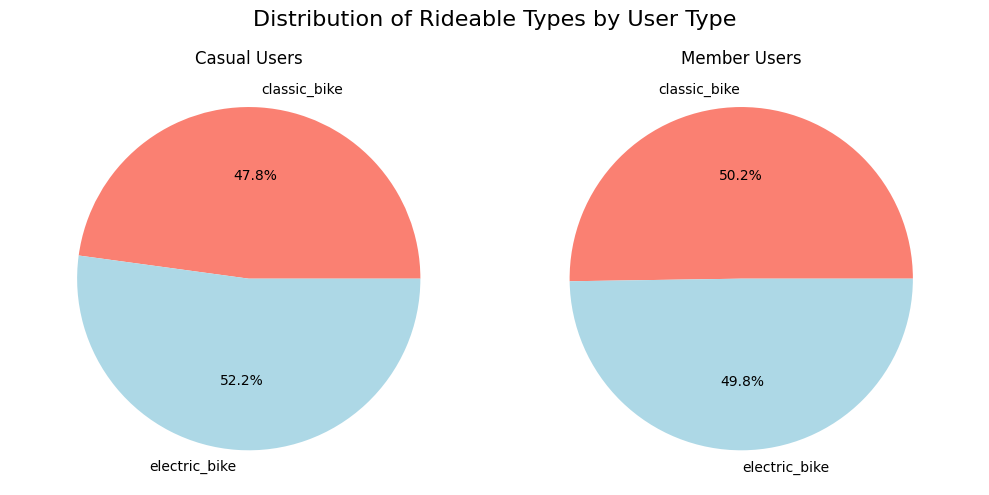

In [16]:
grouped = df.groupby(['user_type', 'rideable_type']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Distribution of Rideable Types by User Type', fontsize=16)

for ax, (user, counts) in zip(axes, grouped.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors = colors)
    ax.axis('equal')
    ax.set_title(f'{user.capitalize()} Users')
plt.tight_layout()
plt.show()

We can see that the type of bikes that casual riders and member riders use doesn't differ drastically. There is a slight increase in electric bike usage by casual riders which makes sense for leisure rides. Lets look at some other factors like time of day.

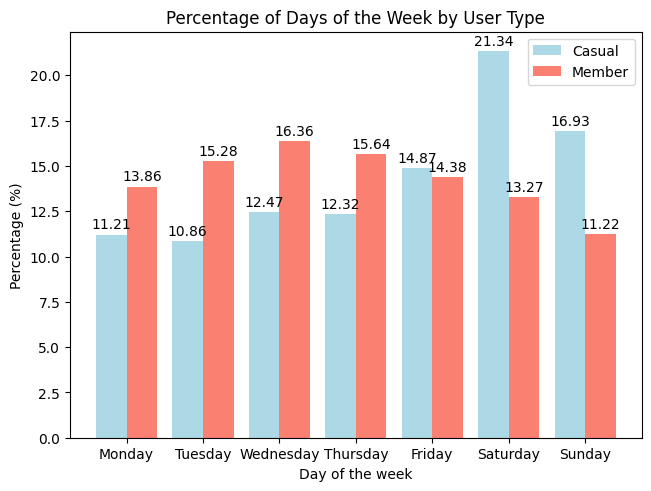

In [17]:
wdays = df.groupby(['day_of_week', 'user_type']).size().unstack(fill_value = 0)

# sorting index to be in chronological order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wdays.index = pd.Categorical(wdays.index, categories=days_order, ordered=True)
wdays.sort_index(inplace=True)

# calculating the percentage of each day for each user type
totals = wdays.sum(axis=0)
percentages = wdays.div(totals, axis=1) * 100
percentages = percentages.round(2)

labels = percentages.index
casual = percentages['casual']
member = percentages['member']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars
fig, ax = plt.subplots(layout='constrained')
b1 = ax.bar(x - width/2, casual, width, label = 'Casual', color='lightblue')
b2 = ax.bar(x + width/2, member, width, label = 'Member', color='salmon')

#labels    
ax.set_xlabel('Day of the week')
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Days of the Week by User Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(b1, padding=2, fmt="%.2f")
ax.bar_label(b2, padding=2, fmt="%.2f")
plt.show()

Since the number of observations for member riders is significantly higher than casual riders, I calculated the percentage of riders for each day, to normalize the data relative to the size of each group. This allows for a fair comparison despite the difference in the number of observations. We can see that during the week member riders rent bikes more frequently and then there is a sizable increase in rented bikes for causal riders on the weekends. This seems reasonable as member riders are most likely people who use the bikes to get to work, school and in general as a means of transportation in the city. Casual riders would be renting bikes for more leisure activities which is more likely to happen on the weekends.

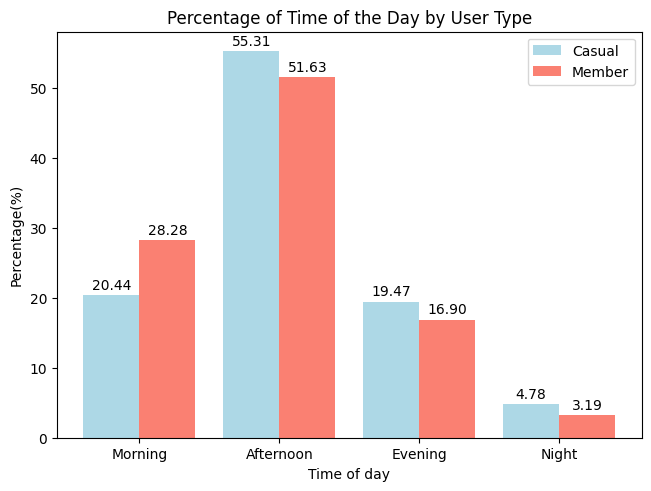

In [18]:
tday = df.groupby(['time_of_day', 'user_type']).size().unstack()

# sorting index to be in chronological order
timeline = ['Morning', 'Afternoon', 'Evening', 'Night']
tday.index = pd.Categorical(tday.index, categories=timeline, ordered=True)
tday.sort_index(inplace=True)

percentage = tday.div(totals, axis = 1) * 100

# data to visualize
labels = percentage.index
casual = percentage['casual']
member = percentage['member']

x = np.arange(len(labels))
width = 0.4
fig, ax = plt.subplots(layout='constrained')
p1 = ax.bar(x - width/2, casual, width, label='Casual', color = 'lightblue')
p2 = ax.bar(x + width/2, member, width, label='Member', color='salmon')

# labels
ax.set_ylabel("Percentage(%)")
ax.set_xlabel("Time of day")
ax.set_title("Percentage of Time of the Day by User Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(p1, padding=2, fmt="%.2f")
ax.bar_label(p2, padding=2, fmt="%.2f")
plt.show()

I want to see how riders compare in the time of day that they used a bike. Members use bikes more frequently in the morning, which goes along with my hypothesis that member riders use bikes more frequently during the week because they use them to get to work or school. Casual riders are utilizing the bikes for more leisure activities so they rent bikes on the weekends and later on in the day. 

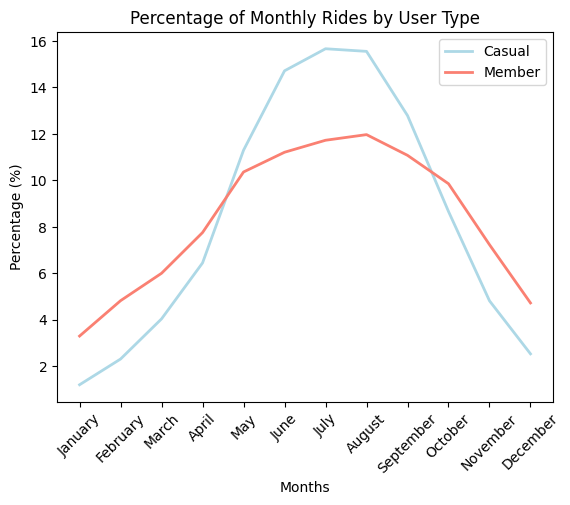

In [19]:
months = df.groupby(['month', 'user_type']).size().unstack(fill_value=0)
m_percent = months.div(totals, axis=1) * 100

# sorting intdex in chronological order
month_category = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
m_percent.index = pd.Categorical(m_percent.index, categories=month_category, ordered=True)
m_percent.sort_index(inplace=True)

fig, ax = plt.subplots()
l1 = ax.plot(m_percent.index, m_percent['casual'], label='Casual', color='lightblue', linestyle='-', linewidth=2)
l2 = ax.plot(m_percent.index, m_percent['member'], label='Member', color='salmon', linestyle='-', linewidth=2)

# labels
ax.set_xlabel('Months')
plt.xticks(rotation=45)
#ax.set_xticks(rotation=45)
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Monthly Rides by User Type')
ax.legend()
plt.show()

As seen above there is a significant increase in the rides taken by casual riders in the summer months, we can see that casual riders tend to use the bikes more when it's warmer outside. Lets take a look at the duration of the rides between casual and member riders.

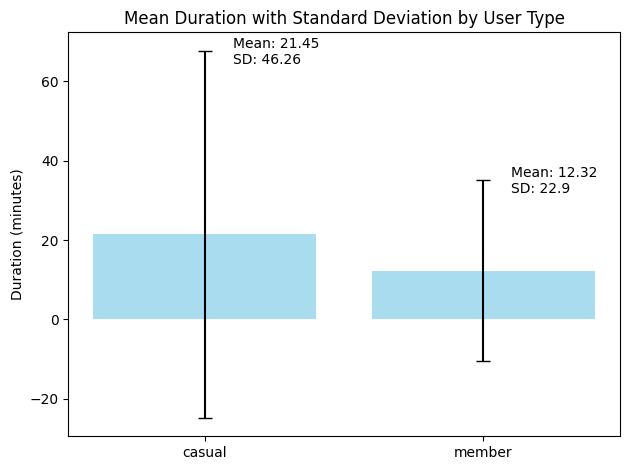

In [20]:
summary_stats = df.groupby('user_type')['duration_min'].agg(['mean', 'std']).reset_index()

# data to visualize
means = summary_stats['mean']
std_devs = summary_stats['std']
labels = summary_stats['user_type']

x = np.arange(len(labels))
fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=std_devs, capsize=5, color='skyblue', alpha=0.7)

# labels
for i in range(len(means)):
    ax.text(x[i] + 0.1, means[i] + std_devs[i], f'Mean: {round(means[i],2)}', ha='left',va='bottom')
    ax.text(x[i] + 0.1, means[i] + std_devs[i] - 4, f'SD: {round(std_devs[i],2)}', ha='left', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Duration (minutes)')
ax.set_title('Mean Duration with Standard Deviation by User Type')
#ax.bar_label(bars, padding=2, fmt=f'mean: %.2f')
plt.tight_layout()
plt.show()

We can see that the average ride time for casual riders is longer then member riders, and there is also more variation in ride times for casual riders.

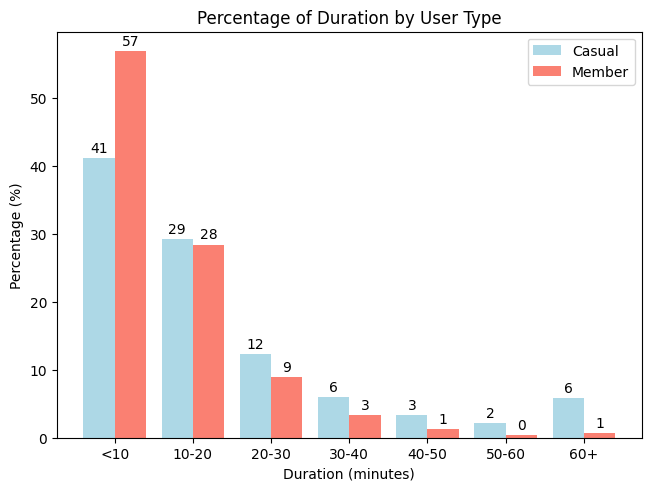

In [21]:
category_counts = df.groupby(['duration_bin', 'user_type'], observed=True).size().unstack(fill_value=0)
percentages = category_counts.div(totals, axis=1) * 100

labels = percentages.index
x = np.arange(len(labels))
width = 0.4
fig, ax = plt.subplots(layout='constrained')
b1 = ax.bar(x - width/2, percentages['casual'], width, label='Casual', color = 'lightblue')
b2 = ax.bar(x + width/2, percentages['member'], width, label='Member', color='salmon')

ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Duration (minutes)")
ax.set_title("Percentage of Duration by User Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(b1, padding=2, fmt="%.0f")
ax.bar_label(b2, padding=2, fmt="%.0f")
plt.show()

Member riders tend to have shorter trips then casual riders. Let's see if there's a difference in the distance traveled.

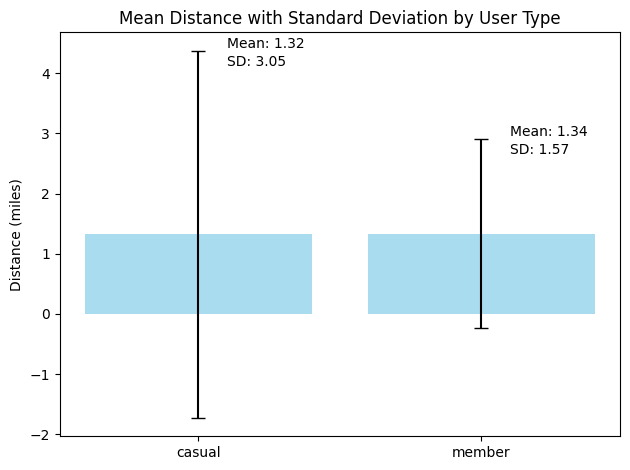

In [22]:
summary_stats = df.groupby('user_type')['distance_mi'].agg(['mean', 'std']).reset_index()
means = summary_stats['mean']
std_devs = summary_stats['std']
labels = summary_stats['user_type']
x = np.arange(len(labels))
fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=std_devs, capsize=5, color='skyblue', alpha=0.7)

# labels
for i in range(len(means)):
    ax.text(x[i] + 0.1, means[i] + std_devs[i], f'Mean: {round(means[i],2)}', ha='left',va='bottom')
    ax.text(x[i] + 0.1, means[i] + std_devs[i] - 0.3, f'SD: {round(std_devs[i],2)}', ha='left', va='bottom')

    ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Distance (miles)')
ax.set_title('Mean Distance with Standard Deviation by User Type')
plt.tight_layout()
plt.show()

The average minimum distance traveled by both is almost equal, but as mentioned previously this doesn't accurately reflect the actual distance traveled. It would be benefical to have data that includes the distance, which is something to consider for future analysis.

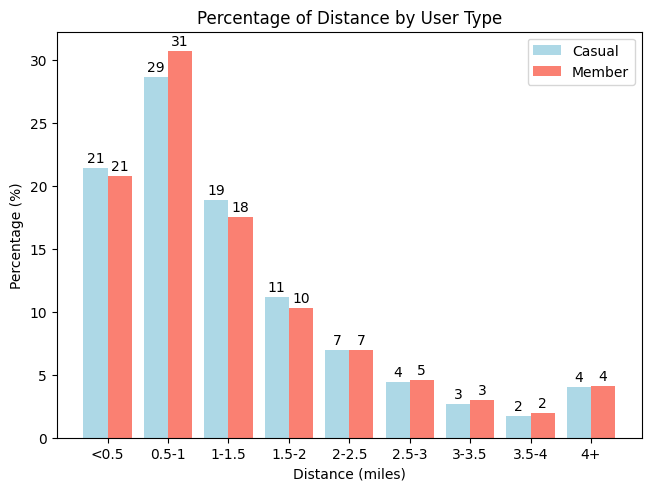

In [23]:
category_counts = df.groupby(['distance_bin', 'user_type'], observed=True).size().unstack(fill_value=0)
percentages = category_counts.div(totals, axis=1) * 100
labels = percentages.index
x = np.arange(len(labels))
width = 0.4
fig, ax = plt.subplots(layout='constrained')
b1 = ax.bar(x - width/2, percentages['casual'], width, label='Casual', color = 'lightblue')
b2 = ax.bar(x + width/2, percentages['member'], width, label='Member', color='salmon')

ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Distance (miles)")
ax.set_title("Percentage of Distance by User Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(b1, padding=2, fmt="%.0f")
ax.bar_label(b2, padding=2, fmt="%.0f")
plt.show()

There isn't a significant difference in distance traveled between casual and member riders but we know that casual riders have longer ride durations so it's safe to assume that they travel longer distances as well. Let's take a closer look at the most popular routes for casual and member riders.

In [24]:
filtered_df = df[(df['start_lat'] != df['end_lat']) & (df['start_lng'] != df['end_lng'])] # filtering out rows where start and end coordinates are the same

coordinates = filtered_df.groupby(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'user_type']).size().reset_index(name='count')

# finding the top 200 routes taken by both user types
casual = coordinates[coordinates['user_type'] == 'casual']
casual_top_200 = casual.nlargest(200, 'count')
member = coordinates[coordinates['user_type'] == 'member']
member_top_200 = member.nlargest(200, 'count')



In [25]:
# coordinates for the start position on the map
central_lat = 41.834734
central_lng = -87.625813
casual_max = casual_top_200['count'].max()

cmap = folium.Map([central_lat, central_lng], zoom_start=15)

for index,row in casual_top_200.iterrows():
    folium.CircleMarker([row['start_lat'], row['start_lng']],
                        radius=1,
                        color = 'red',
                        fill_color='red',
                       ).add_to(cmap) # start point

    folium.CircleMarker([row['end_lat'], row['end_lng']],
                        radius=1,
                        color='red',
                        fill_color='red',
                       ).add_to(cmap) # end point

    folium.PolyLine([[row['start_lat'], row['start_lng']],
                     [row['end_lat'], row['end_lng']]],
                    color = 'red',
                    weight = row['count']/ casual_max + 0.25, # added weight based on normalized path count
                    opacity = 0.6
                    ).add_to(cmap)

In [26]:
# adding member riders top 200 routes to the map
member_max = member_top_200['count'].max()
for index,row in member_top_200.iterrows():
    folium.CircleMarker([row['start_lat'], row['start_lng']],
                        radius=1,
                        color = 'blue',
                        fill_color='blue',
                       ).add_to(cmap)

    folium.CircleMarker([row['end_lat'], row['end_lng']],
                        radius=1,
                        color='blue',
                        fill_color='blue',
                       ).add_to(cmap)

    folium.PolyLine([[row['start_lat'], row['start_lng']],
                     [row['end_lat'], row['end_lng']]],
                    color = 'blue',
                    opacity = 0.6,
                    weight = row['count']/ member_max + 0.25,
                    ).add_to(cmap)
cmap

This map shows the most popular routes taken by casual riders in red and member riders in blue. In doing this we can see that casual riders are more centralized in the city, if they are using the bikes for leisure they would probably be using it for sightseeing or to explore the city for fun. Member riders are more spread out in this city most likely because of their commute to work, school, or errands. This map can also be useful to see where more advertising should be done for casual riders. 

# Share Phase
Now that we have analyzed our data, let's answer some questions we initially wanted to know from the "Ask" phase. 
1. How are casual riders and annual members different?

    From our analysis, we can see that casual riders utilize the bikes for more leisure activities. They use bikes more frequently on weekends, in the warmer months of the year and they tend to have routes more central to the city. These riders utilize the bikes for sightseeing, exploring the city, or enjoying a nice summer day whereas member riders generally use them more consistently as a means of transportation.
    
2. Why would casual riders buy cyclistic annual memberships?

    Buying a membership would be beneficial because it would be cheaper in the long run if they utilized the bikes a couple of times. It is a great way to start a healthier lifestyle, a cheaper alternative to gas, and reduces carbon emissions for those who care about environmental health.  
    
3. How can cyclistic use digital media to influence casual riders to become annual members?

    Cyclistic can use digital media to highlight the benefits of becoming an annual member through different campaigns and promotional strategies. 

# Act Phase

Here are my reommendations on converting casual riders to member riders
1. Run a campaign highlighting how much money can be saved by getting an annual membership. This can be done during the peak summer months, so people are more compelled to rent bikes frequently.
2. Start a TikTok campaign to highlight the health benefits of riding bikes and the environmental impact people can make by opting to ride bikes instead. TikTok is used by a wide range of people, but especially younger adults who are more likely to ride bikes often.
3. Run a promotional offer for current casual riders to become annual members at a discounted rate. People who already have rented the bikes and felt like they were useful are more likely to rent them again. 